In [1]:
# pip install nltk

In [2]:
import pandas as pd
import numpy as np
import re
import string

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
# ML Libraries
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from scipy.sparse import hstack, coo_matrix

import matplotlib.pyplot as plt
import seaborn as sns 
from datetime import datetime
from scipy.sparse import hstack, coo_matrix

In [3]:
#Read the development set and drop columns ids, flag and user
df1 = pd.read_csv("development.csv", encoding='latin-1')
df1 = df1.drop(["ids","flag"],axis=1)

#Read the evaluation set and drop the columns ids, flag and user
df2 = pd.read_csv("evaluation.csv",encoding='latin-1')
df2 = df2.drop(["ids","flag"],axis=1)


In [4]:
#Create a vector containing the text column from both datasets
tweets=df1["text"]
tweets=tweets.append(df2["text"])

#Create a vector containing the sentiment column from the development set
sentiments=df1["sentiment"]

#Create a vector containing the date column from both datasets
date=df1["date"]
date=date.append(df2["date"])

#Create a vector containing all the user names from both datasets
usernames = df1.user
usernames = usernames.append(df2.user)

In [5]:
#Create a function to convert the datetime attribute into a dmy format
def time_to_seconds(timestamp):
    dmy=str(timestamp)[4:10]+" "+str(timestamp)[24:32]
    dmy=datetime.strptime(dmy, '%b %d %Y')
    return(dmy)

In [6]:
#DATA EXPLORATION

#Apply the time_to_seconds function to all the instances in the evaluation set
dates = df1.date.apply(lambda x: time_to_seconds(x)).unique()

In [7]:
#Compute the number of positive and negative tweets per day
df1.date = df1.date.apply(lambda x: time_to_seconds(x))
size_by_date = df1.groupby("date").size()
size_by_date = pd.Series(size_by_date, dates)
positive_by_date = df1.groupby("date").sum()
positive_by_date = pd.Series(positive_by_date.sentiment, dates)
negative_by_date = size_by_date - positive_by_date

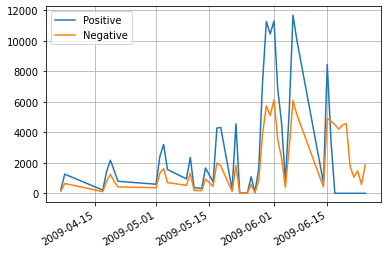

In [8]:
#Plot
plot_df = pd.DataFrame()
plot_df["Positive"] = positive_by_date
plot_df["Negative"] = negative_by_date
graph = plot_df.plot(grid = True)
graph.figure.savefig("plots.pdf")

In [9]:
#Compute the number of positive and negative tweets per user
users = df1.user.unique()
size_by_user = df1.groupby("user").size()
size_by_user = pd.Series(size_by_user, users)
positive_by_user = df1.groupby("user").sum()
positive_by_user = pd.Series(positive_by_user.sentiment, users)
negative_by_user = size_by_user - positive_by_user

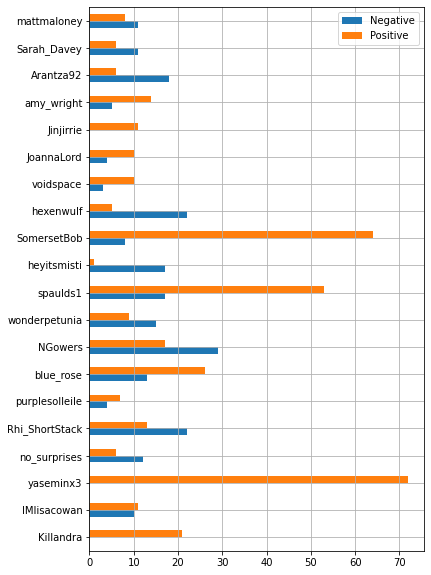

In [15]:
#Plot
plot_df = pd.DataFrame()
plot_df["Positive"] = positive_by_user
plot_df["Negative"] = negative_by_user
plot_df["Delta_user"] = plot_df.Positive - plot_df.Negative
plot_df["Total"] = plot_df["Negative"] + plot_df["Positive"]
graph = plot_df[["Negative","Positive"]][:20]


ax=graph.plot.barh(rot=0,figsize=(6,10),grid=True)
ax.figure.savefig("pos_neg_peruser.pdf",bbox_inches='tight')


In [10]:
plot_df.sort_values("Total", ascending=False)

,Positive,Negative,Delta_user,Total
lost_dog,0,412,-412,412
webwoke,63,196,-133,259
tweetpet,0,232,-232,232
SallytheShizzle,69,142,-73,211
VioletsCRUK,166,43,123,209
...,...,...,...,...
shadowsinstone,11,0,11,11
lovenadav,10,1,9,11
SharaBlckBarbie,2,9,-7,11
mementototem,4,7,-3,11


In [11]:
####DATA PREPARATION


#Transform the actual usernames to the more valuable information "Delta_user"
usernames = [plot_df.Delta_user.loc[username] for username in usernames]

In [12]:
#Initializing the emoticons dictionaries
emoticons_happy = set([
    ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
    ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
    '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
    'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
    '<3'
    ])

emoticons_sad = set([
    ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
    ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', '>.>','<.<' ":'-(", ":'(", ':\\', ':-c',
    ':c', ':{', '>:\\', ';(',">_<",">_>"
    ])

In [17]:
#Defining the preprocessing function

def preprocess(tweet):
    #Transforming all characters into lower case ones
    tweet=tweet.lower()     
    
    # Remove urls
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)
    
    # Remove user @ references and '#' from tweet
    tweet = re.sub(r'\@\w+|\#','', tweet)
    
    # Substitute meaningless query expressions to the english equivalent
    tweet = re.sub(r"&amp;"," and ", tweet)
    tweet = re.sub(r"&quot;","",tweet)
    tweet = re.sub(r"&lt;","<", tweet)
    tweet = re.sub(r"&gt;",">",tweet)
    #tweet = re.sub(r"<3","loveheart",tweet)

    # Convert emojis into their meaning
    # This is done before removing punctuation, to not lose the emojis
    tweet=" ".join([w if not w in emoticons_happy else "HAPPY" for w in tweet.split()])
    tweet=" ".join([w if not w in emoticons_sad else "SAD" for w in tweet.split()])
    
    # Remove punctuations
    tweet = tweet.translate(str.maketrans('', '', string.punctuation))
    
    # Remove stopwords
    # tweet_tokens = word_tokenize(tweet)
    # filtered_words = [w for w in tweet_tokens if ((not w in stop_words) and (not w in string.punctuation))]
    
    #Stemming
    #ps = PorterStemmer()
    #tweet_tokens = word_tokenize(tweet)
    #stemmed_words = [ps.stem(w) for w in tweet_tokens]
    
    return tweet
    #return " ".join(filtered_words)
    #return " ".join(stemmed_words) 

In [15]:
#Eliminating repeated characters, e.g: itttttt ====> it
def rep_char(text):
    return re.sub(r'(\w)\1(\1+)',r'\1',text)

In [13]:
#Define a function that returns the tokenized tweets and a dictionary that contains as keys all the different tokens
#and as values the frequency of the corresponding key among the whole dataset

def total_TF(tweets):
    
    #This function, given a list of tweets, will return a dictionary containing the term frequency of every word across
    #the whole list.
    
    #Step 1: Tokenize every tweet and create a list in which each entry contains the tokens in a specific tweet
    tokens = []
    for tweet in tweets:
        split_tweet = [ token for token in tweet.split(" ") if token ]
        tokens.append(split_tweet)
        
    
    #Step 2: Compute the term frequency of words within each tweet
    TF = []
    for tweet in tokens:
        tf = {}
        for token in tweet:
            tf[token] = tf.get(token, 0) + 1
        TF.append(tf)

    
    #Step 3: Sum the term frequencies of every specific word within each tweet across all the tweets. It willl result
    #in a dictionary containg as keys all the words in the collections of tweets and as values the frequency of the 
    #corresponding word across the whole collection
    total_TF = {}
    for tweet_tf in TF:
        for token, token_tf in tweet_tf.items():
            total_TF[token] = total_TF.get(token, 0) + token_tf
    
    #returns the tokenized tweets and the total token frequency
    return tokens, total_TF

In [14]:
#Function that converts the collection of documents into a tfidf matrix
def get_feature_vector(tweet):
    tweet_v = TfidfVectorizer(sublinear_tf=True)
    tweet_v.fit(tweet)
    return tweet_v

In [18]:
#I apply the preprocess on every tweet of either set
tweets_prepro=tweets.apply(preprocess)

In [19]:
#Remove repeated characters
tweets_prepro = tweets_prepro.apply(lambda x: rep_char(x))

In [20]:
#Tokenize the tweets, create a token frequency dictionary
tokenized_tweets, TF_dictionary = total_TF(tweets_prepro)

#Remove unfrequent tokens
frequent_dictionary = {key:TF_dictionary[key] for key, freq in TF_dictionary.items() if freq>3}
frequent_word_tweet = [[token for token in tokenized_tweets[i] if token in frequent_dictionary.keys()]\
                       for i in range(len(tokenized_tweets))]
tweets_prepro = frequent_word_tweet

In [21]:
#Recreate the tweets using only the frequent tokens selected from before
tweets_prepro=[" ".join(tweet_prepro) for tweet_prepro in tweets_prepro]

In [22]:
#Vectorise every tweet in either set
tf_vector = get_feature_vector(np.array(tweets_prepro).ravel())
#create a datatframe
df = tf_vector.transform(np.array(tweets_prepro).ravel())



In [23]:
#Transform all dates into the format dd-mm-yyyy
date=date.apply(lambda x: time_to_seconds(x))

In [24]:
#Express all dates as days passed from the date of the earliest tweet in the dataset
deltas_dates=date-min(date)
deltas_dates=deltas_dates.dt.days

In [25]:
#transform series usernames into an array
usernames = np.array(usernames)

In [26]:
#Transform the delta vectors in column vectors
deltas_dates = deltas_dates[:, np.newaxis]
deltas_usernames = usernames[:, np.newaxis]

<ipython-input-26-6f6e2586df53>:2: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  deltas = deltas[:, np.newaxis]


In [27]:
deltas_usernames

array([[ 21],
       [  1],
       [ 72],
       ...,
       [-36],
       [ -7],
       [ 21]], dtype=int64)

In [28]:
#Stack the dataframe  together with the new delta column
dff=hstack((df,deltas_dates))
dfff=hstack((dff,deltas_usernames))
#convert it back into csr matrix
dfff=dfff.tocsr()

In [29]:
#Separate the now preprocesssed development set from the evaluation set.
#Divide the development set into a training and a test set
X=dfff[:len(df1["text"])]
y = np.array(sentiments).ravel()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)

In [30]:
# Training Logistics Regression model
LR_model = LogisticRegression(max_iter=2000)
LR_model.fit(X_train, y_train)
y_predict_lr = LR_model.predict(X_test)
print(accuracy_score(y_test, y_predict_lr))
print(f1_score(y_test, y_predict_lr, average = "macro"))

0.8357519055979021
0.8302602377195947


Two equivalent version of this code were run, with stemming (F1-score approximately equal to 0.827) and without stemming (F1-score approximately equal to 0.830)

In [80]:
#Training a SVM classifier
tweet_class = SVC(C=10,kernel="poly")
tweet_class.fit(X_train, y_train)
y_predict_SVC= tweet_class.predict(X_test)
print(accuracy_score(y_test, y_predict_SVC))
print(f1_score(y_test, y_predict_SVC,average="macro"))


#Results (accuracy and f1 score)
# 0.7728393964310318
# 0.7588150028697033

#(C=10)
# 0.8014844774328318
# 0.7914171526761238

#(C=10, kernel="poly")
# 0.7797951065579235
# 0.7610679476240622

0.7797951065579235
0.7610679476240622


The following configurations of "kernel" and "C" have been tried: 
{C=1,"kernel"="rbf} = 0.759
{C=10,"kernel"="rbf"} = 0.791
{C=10,"kernel"="poly"} = 0.761

In [26]:
#Gridsearch on the Random Forest
param_grid={"criterion":["entropy","gini"],"n_estimators":[100],"max_features":["sqrt","log2","auto"]}
grid=GridSearchCV(RandomForestClassifier(),param_grid,refit=False,verbose=3,cv=2,scoring="f1_macro")
grid.fit(X_train,y_train)
print(grid.best_params_)
print(grid.best_estimator_)

grid_predictions=grid.predict(X_test)
print(f1_score(y_test, grid_predictions))

#Fitting 2 folds for each of 24 candidates, totalling 48 fits
#[CV 1/2] END criterion=entropy, max_depth=None, max_features=sqrt, n_estimators=100;, score=0.841 total time= 7.6min
#[CV 2/2] END criterion=entropy, max_depth=None, max_features=sqrt, n_estimators=100;, score=0.842 total time= 6.0min
#[CV 1/2] END criterion=entropy, max_depth=None, max_features=sqrt, n_estimators=200;, score=0.843 total time=14.0min
#[CV 2/2] END criterion=entropy, max_depth=None, max_features=sqrt, n_estimators=200;, score=0.844 total time=12.4min
#[CV 1/2] END criterion=entropy, max_depth=None, max_features=log2, n_estimators=100;, score=0.845 total time= 7.0min
#[CV 2/2] END criterion=entropy, max_depth=None, max_features=log2, n_estimators=100;, score=0.844 total time= 7.3min
#[CV 1/2] END criterion=entropy, max_depth=None, max_features=log2, n_estimators=200;, score=0.848 total time=15.9min
#[CV 2/2] END criterion=entropy, max_depth=None, max_features=log2, n_estimators=200;, score=0.848 total time=14.5min
#[CV 1/2] END criterion=entropy, max_depth=2, max_features=sqrt, n_estimators=100;, score=0.733 total time=   2.9s
#[CV 2/2] END criterion=entropy, max_depth=2, max_features=sqrt, n_estimators=100;, score=0.733 total time=   2.9s
#[CV 1/2] END criterion=entropy, max_depth=2, max_features=sqrt, n_estimators=200;, score=0.733 total time=   6.0s
#[CV 2/2] END criterion=entropy, max_depth=2, max_features=sqrt, n_estimators=200;, score=0.733 total time=   5.5s
#[CV 1/2] END criterion=entropy, max_depth=2, max_features=log2, n_estimators=100;, score=0.733 total time=   2.0s
#[CV 2/2] END criterion=entropy, max_depth=2, max_features=log2, n_estimators=100;, score=0.733 total time=   2.0s
#[CV 1/2] END criterion=entropy, max_depth=2, max_features=log2, n_estimators=200;, score=0.733 total time=   4.6s
#[CV 2/2] END criterion=entropy, max_depth=2, max_features=log2, n_estimators=200;, score=0.733 total time=   4.4s
#[CV 1/2] END criterion=entropy, max_depth=10, max_features=sqrt, n_estimators=100;, score=0.741 total time=  10.1s
#[CV 2/2] END criterion=entropy, max_depth=10, max_features=sqrt, n_estimators=100;, score=0.741 total time=   9.5s
#[CV 1/2] END criterion=entropy, max_depth=10, max_features=sqrt, n_estimators=200;, score=0.735 total time=  19.5s
#[CV 2/2] END criterion=entropy, max_depth=10, max_features=sqrt, n_estimators=200;, score=0.744 total time=  19.8s
#[CV 1/2] END criterion=entropy, max_depth=10, max_features=log2, n_estimators=100;, score=0.733 total time=   4.6s
#[CV 2/2] END criterion=entropy, max_depth=10, max_features=log2, n_estimators=100;, score=0.733 total time=   4.4s
#[CV 1/2] END criterion=entropy, max_depth=10, max_features=log2, n_estimators=200;, score=0.733 total time=   9.4s
#[CV 2/2] END criterion=entropy, max_depth=10, max_features=log2, n_estimators=200;, score=0.733 total time=   9.4s
#[CV 1/2] END criterion=gini, max_depth=None, max_features=sqrt, n_estimators=100;, score=0.841 total time= 5.6min
#[CV 2/2] END criterion=gini, max_depth=None, max_features=sqrt, n_estimators=100;, score=0.841 total time= 8.3min
#[CV 1/2] END criterion=gini, max_depth=None, max_features=sqrt, n_estimators=200;, score=0.843 total time=16.7min
#[CV 2/2] END criterion=gini, max_depth=None, max_features=sqrt, n_estimators=200;, score=0.843 total time=32.9min
#[CV 1/2] END criterion=gini, max_depth=None, max_features=log2, n_estimators=100;, score=0.843 total time=15.2min
#[CV 2/2] END criterion=gini, max_depth=None, max_features=log2, n_estimators=100;, score=0.844 total time=14.0min
#[CV 1/2] END criterion=gini, max_depth=None, max_features=log2, n_estimators=200;, score=0.848 total time=29.5min
#[CV 2/2] END criterion=gini, max_depth=None, max_features=log2, n_estimators=200;, score=0.847 total time=21.1min
#[CV 1/2] END criterion=gini, max_depth=2, max_features=sqrt, n_estimators=100;, score=0.733 total time=   6.0s
#[CV 2/2] END criterion=gini, max_depth=2, max_features=sqrt, n_estimators=100;, score=0.733 total time=   6.5s
#[CV 1/2] END criterion=gini, max_depth=2, max_features=sqrt, n_estimators=200;, score=0.733 total time=  12.6s
#[CV 2/2] END criterion=gini, max_depth=2, max_features=sqrt, n_estimators=200;, score=0.733 total time=  12.3s
#[CV 1/2] END criterion=gini, max_depth=2, max_features=log2, n_estimators=100;, score=0.733 total time=   4.5s
#[CV 2/2] END criterion=gini, max_depth=2, max_features=log2, n_estimators=100;, score=0.733 total time=   3.2s
#[CV 1/2] END criterion=gini, max_depth=2, max_features=log2, n_estimators=200;, score=0.733 total time=   5.0s
#[CV 2/2] END criterion=gini, max_depth=2, max_features=log2, n_estimators=200;, score=0.733 total time=   4.1s
#[CV 1/2] END criterion=gini, max_depth=10, max_features=sqrt, n_estimators=100;, score=0.736 total time=  11.0s
#[CV 2/2] END criterion=gini, max_depth=10, max_features=sqrt, n_estimators=100;, score=0.738 total time=  10.6s
#[CV 1/2] END criterion=gini, max_depth=10, max_features=sqrt, n_estimators=200;, score=0.735 total time=  21.3s
#[CV 2/2] END criterion=gini, max_depth=10, max_features=sqrt, n_estimators=200;, score=0.740 total time=  21.5s
#[CV 1/2] END criterion=gini, max_depth=10, max_features=log2, n_estimators=100;, score=0.733 total time=   5.6s
#[CV 2/2] END criterion=gini, max_depth=10, max_features=log2, n_estimators=100;, score=0.733 total time=   5.1s
#[CV 1/2] END criterion=gini, max_depth=10, max_features=log2, n_estimators=200;, score=0.733 total time=  10.1s
#[CV 2/2] END criterion=gini, max_depth=10, max_features=log2, n_estimators=200;, score=0.733 total time=  10.1s

Fitting 2 folds for each of 24 candidates, totalling 48 fits
[CV 1/2] END criterion=entropy, max_depth=None, max_features=sqrt, n_estimators=100;, score=0.841 total time= 7.6min
[CV 2/2] END criterion=entropy, max_depth=None, max_features=sqrt, n_estimators=100;, score=0.842 total time= 6.0min
[CV 1/2] END criterion=entropy, max_depth=None, max_features=sqrt, n_estimators=200;, score=0.843 total time=14.0min
[CV 2/2] END criterion=entropy, max_depth=None, max_features=sqrt, n_estimators=200;, score=0.844 total time=12.4min
[CV 1/2] END criterion=entropy, max_depth=None, max_features=log2, n_estimators=100;, score=0.845 total time= 7.0min
[CV 2/2] END criterion=entropy, max_depth=None, max_features=log2, n_estimators=100;, score=0.844 total time= 7.3min
[CV 1/2] END criterion=entropy, max_depth=None, max_features=log2, n_estimators=200;, score=0.848 total time=15.9min
[CV 2/2] END criterion=entropy, max_depth=None, max_features=log2, n_estimators=200;, score=0.848 total time=14.5min
[CV

AttributeError: 'GridSearchCV' object has no attribute 'best_estimator'

In [27]:
#Grid search for the number of estimators in a Random Forest given the best parameters of the previous one
est=[1,2,3,5,10,15,20,30,40,50,60,75,100,200,500]
scores=[]
n_iter=0
for val in est:
    RF_clf = RandomForestClassifier(n_estimators=val, max_features="log2", criterion = "entropy")
    RF_clf.fit(X_train, y_train)
    y_predict_RF = RF_clf.predict(X_test)
    scores.append(f1_score(y_test, y_predict_RF,average="macro"))
    print(scores[n_iter],est[n_iter])
    n_iter+=1


[0.7297091807641132]
[0.7297091807641132, 0.631713613414662]
[0.7297091807641132, 0.631713613414662, 0.7543968084508624]
[0.7297091807641132, 0.631713613414662, 0.7543968084508624, 0.7288808067449165]
[0.7297091807641132, 0.631713613414662, 0.7543968084508624, 0.7288808067449165, 0.7788550494023609]
[0.7297091807641132, 0.631713613414662, 0.7543968084508624, 0.7288808067449165, 0.7788550494023609, 0.7558160397105437]
[0.7297091807641132, 0.631713613414662, 0.7543968084508624, 0.7288808067449165, 0.7788550494023609, 0.7558160397105437, 0.7980608553537654]
[0.7297091807641132, 0.631713613414662, 0.7543968084508624, 0.7288808067449165, 0.7788550494023609, 0.7558160397105437, 0.7980608553537654, 0.7819032276847233]
[0.7297091807641132, 0.631713613414662, 0.7543968084508624, 0.7288808067449165, 0.7788550494023609, 0.7558160397105437, 0.7980608553537654, 0.7819032276847233, 0.8024322749781532]
[0.7297091807641132, 0.631713613414662, 0.7543968084508624, 0.7288808067449165, 0.7788550494023609,

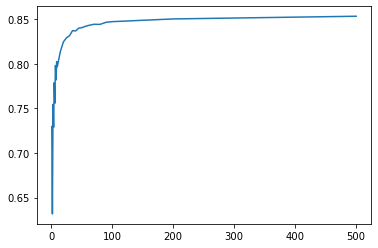

In [137]:
#Plot the f1-score against number of estimators
plt.plot(est,scores)
plt.savefig("f1curve.pdf")

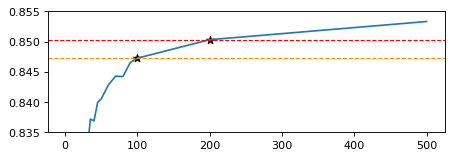

In [138]:
#Zoom to be able to appreciate the difference between the performance with 100 and with 200 classifiers
plt.figure(figsize=(6.4, 2), dpi=80)
plt.plot(est,scores)
plt.axhline(scores[13],color="red",ls="--",lw=1)
#plt.axvline(200,color="red",ls="--",lw=1)
plt.axhline(scores[12],color="darkorange",ls="--",lw=1)
#plt.axvline(100,color="green",ls="--",lw=1)
interest_points=[[100,200],[scores[12],scores[13]]]
plt.scatter(*interest_points, marker='*', color='black',s=50)
plt.ylim(.835, .855)
plt.savefig("zoom_f1curve.pdf")

The chosen configuration is therefore: RandomForestClassifier(criterion='entropy', max_features='log2',                     n_estimators=200), that could be ran once again below.

In [ ]:
RF_clf = RandomForestClassifier(n_estimators=200, max_features="log2", criterion = "entropy")
RF_clf.fit(X_train, y_train)
y_predict_new = RF_clf.predict(X_test)
print(accuracy_score(y_test, y_predict_new))
print(f1_score(y_test, y_predict_new, average = "macro"))



Two equivalent version of this code were run, with stemming (F1-score approximately equal to 0.844) and without stemming (F1-score approximately equal to 0.841)

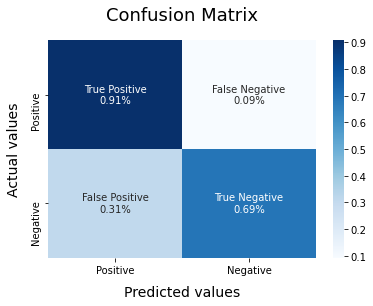

In [147]:
#Plot the confusion matrix
conf_matrix = confusion_matrix(y_test, y_predict_RF,labels=[1,0])
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]*100
classes = ['Positive','Negative']
classes_names = ['True Positive','False Negative', 'False Positive','True Negative']
percentages = list(map('{:.1f}%'.format,conf_matrix.flatten()))
labels = [f'{v1}\n{v2}' for v1, v2 in zip(classes_names,percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(conf_matrix, annot = labels, cmap = 'Blues',fmt = '',
xticklabels = classes, yticklabels = classes)
plt.xlabel("Predicted values", fontdict = {'size':11}, labelpad = 10)
plt.ylabel("Actual values" , fontdict = {'size':11}, labelpad = 10)
plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)


plt.savefig("confusion_matrix.pdf")

In [8]:
#Training the optimal random forest classifier on the whole development for submission
RF_clf = RandomForestClassifier(n_estimators=200, max_features="log2", criterion = "entropy")
RF_clf.fit(X, y)

RandomForestClassifier(criterion='entropy', max_features='log2',
                       n_estimators=200)

In [213]:
#File submission
X2=dfff[len(df1["text"]):]
y_pred=RF_clf.predict(X2)
y_pred

data={"text":df2["text"],"Predicted":y_pred}
df_submit=pd.DataFrame(data)
df_submit

submission=df_submit.to_csv("twitter_sentiment_analysis.csv", index = True)